In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm, t
from scipy.special import gammaln  # For the log-gamma function (in the loglikelilook of the student-t distribution)
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from scipy.stats import skew, kurtosis

In [3]:
# Load our clean data
data = pd.read_csv("data_clean.csv").drop(columns=["Unnamed: 0"]).set_index("day_tick")

In [4]:
data.head()

,day,tick,logprice,log_returns
day_tick,,,,
1.018805,1,0.018805,4.430178,NaN
1.019500,1,0.019500,4.430755,0.000578
1.020195,1,0.020195,4.430030,-0.000725
1.020890,1,0.020890,4.430620,0.000590
1.021585,1,0.021585,4.430702,0.000082


In [5]:
import warnings
warnings.filterwarnings("ignore")

## 1st Step: Is GARCH suitable for our data?

- Stationarity?
- Any trend?
- Changing variability?

- Identify systematic component
- Remaining errors are simple to express
- Seek a parsimonious representation
- Improve understanding of the process

First of all, we resample our data to be daily (explain maybe a little bit that GARCH models perform better in daily data than HF data, cite some paper)

<AxesSubplot: xlabel='day'>

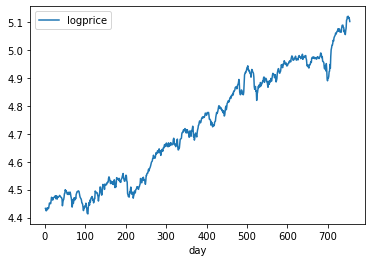

In [6]:
daily_data = data.groupby("day").last()
daily_data["log_returns"] = (daily_data["logprice"] - daily_data["logprice"].shift(1))
daily_data = daily_data.dropna()
daily_data[["logprice"]].plot()

In [7]:
daily_data.index

Index([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
       ...
       745, 746, 747, 748, 749, 750, 751, 752, 753, 754],
      dtype='int64', name='day', length=753)

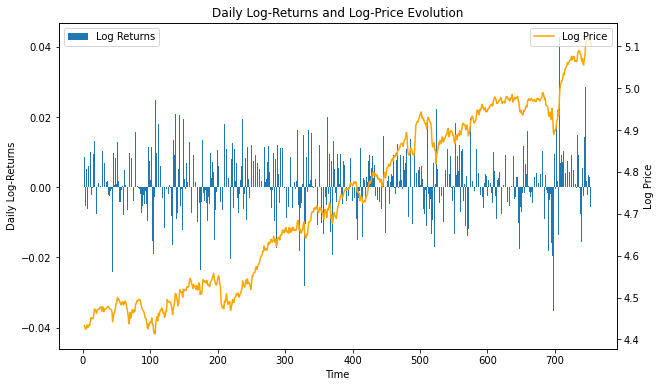

In [8]:
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot log_returns on the primary y-axis
ax1.bar(daily_data.index, daily_data["log_returns"], label='Log Returns')
ax1.set_xlabel("Time")
ax1.set_ylabel("Daily Log-Returns")
ax1.tick_params(axis='y')

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(daily_data["logprice"], color='orange', label='Log Price')
ax2.set_ylabel("Log Price")
ax2.tick_params(axis='y')

# Add a title
plt.title("Daily Log-Returns and Log-Price Evolution")

# Optional: Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.savefig("Returns.png")

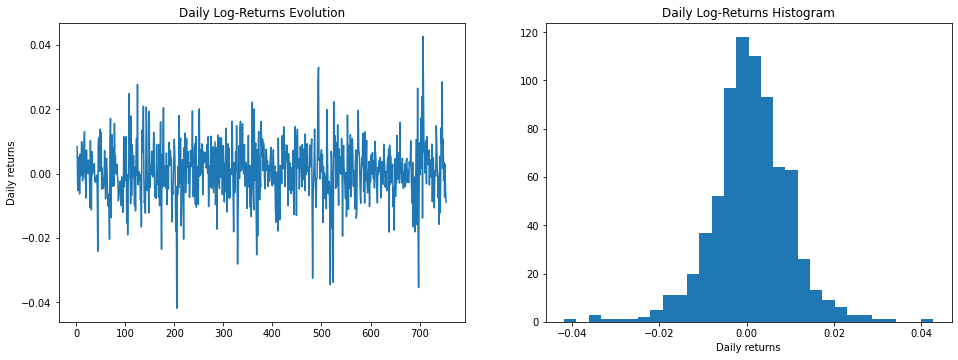

In [9]:
_, axs = plt.subplots(1,2,figsize=(16,5.5))

axs[0].plot(daily_data["log_returns"])
axs[0].set_title("Daily Log-Returns Evolution")
axs[0].set_ylabel("Daily returns")

axs[1].hist(daily_data["log_returns"],bins=30)
axs[1].set_title("Daily Log-Returns Histogram")
axs[1].set_xlabel("Daily returns")
plt.show()

In [10]:
print("Skewness:", skew(daily_data["log_returns"]))
print("Kurtosis:", kurtosis(daily_data["log_returns"], fisher=True)) # Excess Kurtosis

Skewness: -0.2152003728150938
Kurtosis: 2.523772431284666


We notice that Excess Kurtosis is greater than 0, so our returns are fat-tailed. This is good because GARCH models are good in handling fat-tailed returns.

### Stationarity

In [11]:
result = adfuller(daily_data["log_returns"])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] < 0.05:
    print("Series is stationary")
else:
    print("Series is not stationary")


ADF Statistic: -26.197966749123786
p-value: 0.0
Series is stationary


### Volatility Clustering

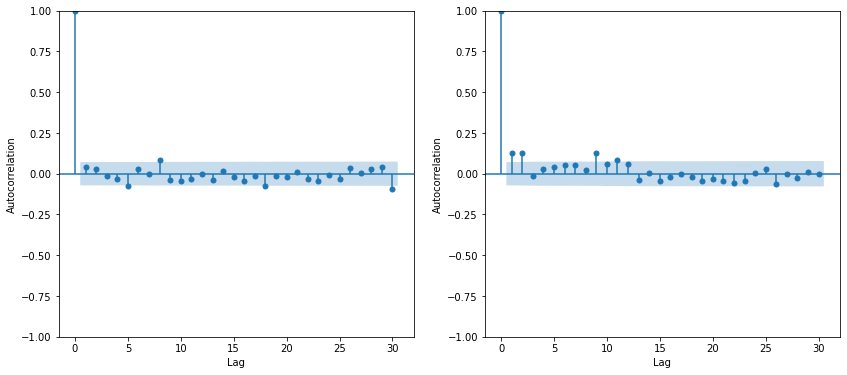

In [37]:
# Plotting ACF of squared returns
_, axs = plt.subplots(1,2,figsize=(14,6))
plot_acf(daily_data["log_returns"], lags=30, ax=axs[0], title="")
plot_acf(daily_data["log_returns"]**2, lags=30, ax=axs[1], title="")
axs[0].set_xlabel("Lag")
axs[0].set_ylabel("Autocorrelation")
axs[1].set_xlabel("Lag")
axs[1].set_ylabel("Autocorrelation")
# plt.title("ACF of Squared Returns")
plt.savefig("ACF.png")

In [13]:
# Apply Ljung-Box test to squared log returns
result = acorr_ljungbox(daily_data["log_returns"]**2, lags=20, return_df=True)

# Print the results
print("Ljung-Box Test Results (for Squared Log Returns):")
result

Ljung-Box Test Results (for Squared Log Returns):


,lb_stat,lb_pvalue
1,11.789602,5.956246e-04
2,23.814130,6.742598e-06
3,23.930931,2.582326e-05
4,24.556587,6.176567e-05
5,25.846342,9.557198e-05
6,28.258493,8.399320e-05
7,30.677039,7.130512e-05
8,30.991141,1.410143e-04
9,43.427919,1.798704e-06
10,46.115228,1.366917e-06


Since the p-values are small, we reject the null-hypothesis that there is not autocorrelation and we sa that there exists autocorrelation of returns and therefore, volatility clustering. With these results, it is reasonable to apply a GARCH model.

## 2nd Step: Estimate GARCH model

The GARCH(1,1) model consists of a mean equation and a variance equation.

### Mean Equation
The mean equation for the returns $ r_t $ is given by:
\begin{equation}
    r_t = \mu + \epsilon_t
\end{equation}

where:

-  $r_t$  is the return at time  t ,
-  $\mu$  is the constant mean of the returns,
-  $\epsilon_t$  is the residual (innovation) term.


### Variance Equation
The residual term $ \epsilon_t $ is modeled as:
\begin{equation}
    \epsilon_t = \sigma_t z_t
\end{equation}
where:

- $ \sigma_t^2 $ is the conditional variance at time $ t $,
- $ z_t \sim N(0, 1) $, meaning $ z_t $ follows a standard normal distribution. We will also use the Student's t-distribution.


The conditional variance $ \sigma_t^2 $ is specified as:
\begin{equation}
    \sigma_{t+1}^2 = \omega + \alpha \epsilon_{t}^2 + \beta \sigma_{t}^2
\end{equation}

where:

- $ \omega > 0 $ is the long-run average variance,
- $ \alpha \geq 0 $ is the ARCH parameter, measuring the impact of past squared residuals,
- $ \beta \geq 0 $ is the GARCH parameter, measuring the persistence of volatility.


### Parameter Conditions
To ensure the GARCH(1,1) model is well-defined, the following conditions must hold:
\begin{equation}
    \omega > 0, \quad \alpha \geq 0, \quad \beta \geq 0, \quad \alpha + \beta < 1
\end{equation}

These conditions ensure that the variance process is stationary and non-negative.

In [14]:
from arch import arch_model

returns = daily_data['log_returns'].dropna().values

# Fit GARCH(1,1) model
model = arch_model(returns, vol='Garch', p=1, q=1, rescale=False)
garch_fit = model.fit(disp="off")

# Print summary
print(garch_fit.summary())

# Access fitted parameters
# params = garch_fit.params

# mu_lib_guess, omega_lib_guess, alpha_lib_guess, beta_lib_guess = params.mu, params.omega, params["alpha[1]"], params["beta[1]"]


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2508.01
Distribution:                  Normal   AIC:                          -5008.01
Method:            Maximum Likelihood   BIC:                          -4989.52
                                        No. Observations:                  753
Date:                Thu, Dec 12 2024   Df Residuals:                      752
Time:                        19:58:33   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         9.9221e-04  1.540e-07   6443.121      0.000 [9.

$$
\log L^c(\theta) = -\frac{1}{2} \sum_{t=q+1}^{n} \left( 
    \log(2 \pi) + \log(\sigma_t^2) 
    + \frac{\epsilon_t^2}{\sigma_t^2} 
\right)
$$


In [ ]:
# Extract the Log Returns
y = daily_data['log_returns'].values
n = len(y)

# Define the Conditional Variance Function
def conditional_variance(params, y, mu):

    omega, alpha, beta = params
    sigma2 = np.zeros_like(y)
    sigma2[0] = np.var(y)  # Set the first element to be the variance of our returns (sample variance)

    for t in range(1, len(y)):
        sigma2[t] = omega + alpha * (y[t-1] - mu)**2 + beta * sigma2[t-1]

    return sigma2


# Define the Negative Log-Likelihood Function
def neg_log_likelihood(params, y, mu):

    omega, alpha, beta = params

    # Parameter constraints (infinite penalty)
    if omega <= 0 or alpha < 0 or beta < 0 or (alpha + beta) >= 1:
        return np.inf

    sigma2 = conditional_variance(params, y, mu)

    # Avoid division by zero or log of zero
    if np.any(sigma2 <= 0):
        return np.inf

    # Log-likelihood assuming normal distribution of residuals (residuals = y - mu)
    ll = -0.5 * (np.log(2 * np.pi) + np.log(sigma2) + ((y - mu)**2) / sigma2)
    
    return -np.sum(ll)  # Negative log-likelihood


# Initial Parameter Guesses
mu = returns.mean()
initial_omega = 1e-5
initial_alpha = 0.1
initial_beta = 0.8
initial_params = [initial_omega, initial_alpha, initial_beta]

# Define Bounds and Constraints
bounds = [(1e-8, None), (0, 1), (0, 1)]  # omega >0, alpha and beta between 0 and1

# Constraint: alpha + beta < 1 for stationarity
constraints = ({
    'type': 'ineq',
    'fun': lambda x: 1 - x[1] - x[2]  # 1 - alpha - beta > 0
})

# Optimize the Parameters
result = minimize(
    neg_log_likelihood,
    initial_params,
    args=(y, mu),
    method='L-BFGS-B',
    bounds=bounds,
    constraints=constraints
)

# Save the results into our variables
fitted_params = result.x
omega_est, alpha_est, beta_est = fitted_params
mu_est = mu


# Show the Results
print("GARCH(1,1) Model Fit Summary")
print("----------------------------")
print(f"mu           : {mu:.6f}")
print(f"omega        : {omega_est:.6f}")
print(f"alpha        : {alpha_est:.6f}")
print(f"beta         : {beta_est:.6f}")
print(f"alpha + beta : {alpha_est + beta_est:.6f}")


GARCH(1,1) Model Fit Summary
----------------------------
mu           : 0.000900
omega        : 0.000009
alpha        : 0.098934
beta         : 0.791474
alpha + beta : 0.890408


## 3rd Step: Volatility estimation

Compute and plot the estimated one step ahead conditional variance to visualize how volatility evolves over time.

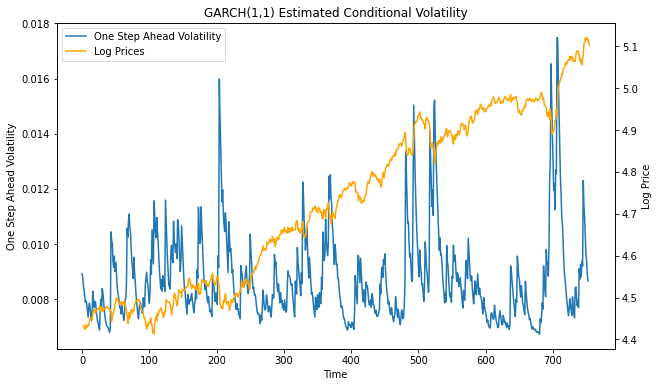

In [16]:

# Compute the fitted conditional variances
sigma2_fitted = conditional_variance(fitted_params, y, mu)
sigma_fitted = np.sqrt(sigma2_fitted)

_, ax1 = plt.subplots(figsize=(10, 6))

line1 = ax1.plot(sigma_fitted, label='One Step Ahead Volatility')
ax1.set_title('GARCH(1,1) Estimated Conditional Volatility')
ax1.set_xlabel('Time')
ax1.set_ylabel('One Step Ahead Volatility')

ax2 = ax1.twinx()
line2 = ax2.plot(daily_data["logprice"], color='orange', label='Log Prices')
ax2.set_ylabel('Log Price')

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left") 

plt.show()


## Step 2.1 Standarized Residuals

Check if the standardized residuals resemble white noise and if their squared values exhibit no remaining autocorrelation effects.

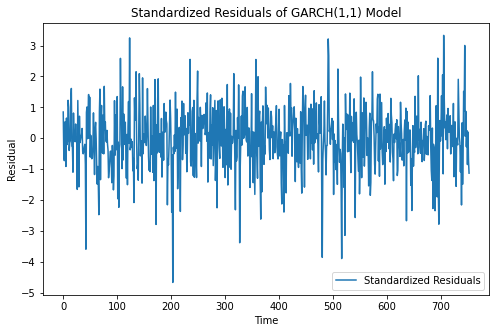

Ljung-Box test on standardized residuals:
      lb_stat  lb_pvalue
1    0.816171   0.366302
2    0.988790   0.609940
3    1.307753   0.727293
4    1.884044   0.757076
5    7.292667   0.199768
6    7.603194   0.268639
7    7.603689   0.368833
8   13.488562   0.096109
9   13.999939   0.122327
10  14.469407   0.152637

Ljung-Box test on squared standardized residuals:
     lb_stat  lb_pvalue
1   0.006301   0.936732
2   2.115843   0.347177
3   5.602654   0.132626
4   5.608725   0.230336
5   5.728605   0.333529
6   6.712218   0.348283
7   6.902914   0.439058
8   7.141918   0.521401
9   7.615645   0.573295
10  7.998290   0.629004


In [17]:
# Compute standardized residuals
standardized_residuals = (returns - mu_est) / sigma_fitted

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(standardized_residuals, label='Standardized Residuals')
plt.title('Standardized Residuals of GARCH(1,1) Model')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.legend()
plt.show()

# Ljung-Box test on residuals
lb_test_resid = acorr_ljungbox(standardized_residuals, lags=10, return_df=True)
print("Ljung-Box test on standardized residuals:")
print(lb_test_resid)

# Ljung-Box test on squared residuals
lb_test_sq_resid = acorr_ljungbox(standardized_residuals**2, lags=10, return_df=True)
print("\nLjung-Box test on squared standardized residuals:")
print(lb_test_sq_resid)


p-values are high, so we fail to reject the null-hypothesis so there is no autocorrelation left, which is what we expect in our GARCH(1,1) model. Also, this implies that we don't need higher p,q in our GARCH(p,q) model since the 1,1 captures all the autocorrelation

## 4th Step: GARCH with Student's t distribution

$$
\log L^c(\theta, \nu) = \sum_{t=q+1}^{n} \left( 
    \Gamma\left(\frac{\nu + 1}{2}\right) 
    - \Gamma\left(\frac{\nu}{2}\right) 
    - \frac{1}{2} \log(\nu \pi \sigma_t^2) 
    - \frac{\nu + 1}{2} \log\left( 1 + \frac{\epsilon_t^2}{\nu \sigma_t^2} \right) 
\right)
$$


We observe that our returns are not Normal but more fat-tailed, so we will use the students't distribution as well for the VaR calculation

In [18]:
returns = np.array(returns) 

# Fit the Student's t-distribution to estimate the degrees of freedom
nu_est, loc, scale = t.fit(returns) 
nu_est = int(np.ceil(nu_est))


print(f"Estimated degrees of freedom (ν): {nu_est}")
print(f"Estimated location (mean): {loc}")
print(f"Estimated scale (std deviation): {scale}")

Estimated degrees of freedom (ν): 5
Estimated location (mean): 0.0010096219509849612
Estimated scale (std deviation): 0.006856982490287419


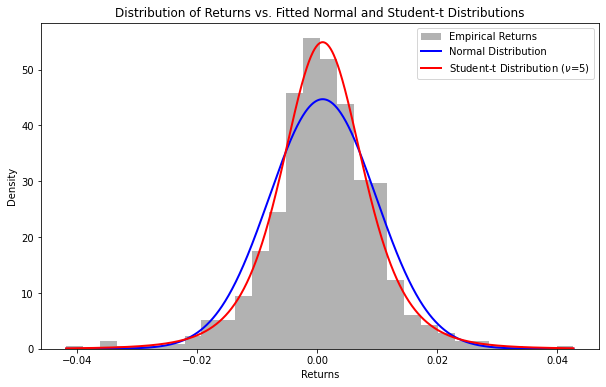

In [19]:
x = np.linspace(min(returns),max(returns),1000)

plt.figure(figsize=(10, 6))
plt.hist(returns, bins=30, density=True, alpha=0.6, color='gray', label='Empirical Returns')
plt.plot(x, norm.pdf(x, loc=returns.mean(), scale=returns.std()), 'b-', label='Normal Distribution', linewidth=2)
plt.plot(x, t.pdf(x, nu_est, loc=returns.mean(), scale=returns.std() * np.sqrt((nu_est - 2) / nu_est)), 'r-', label=r'Student-t Distribution ($\nu}$='+str(nu_est)+")", linewidth=2)
plt.title("Distribution of Returns vs. Fitted Normal and Student-t Distributions")
plt.xlabel("Returns")
plt.ylabel("Density")
plt.legend()
plt.savefig("distribution_fit.png")

We visually observe how a t-student distribution with 5 degrees of freedom fits better our data than a normal distribution

In [20]:
def conditional_variance_t(params, y, mu):

    omega, alpha, beta = params[:3]
    sigma2 = np.zeros_like(y)
    sigma2[0] = np.var(y)  # Initialize with the variance of the data

    for t in range(1, len(y)):
        sigma2[t] = omega + alpha * (y[t-1] - mu)**2 + beta * sigma2[t-1]

    return sigma2


# Negative Log-Likelihood Function for Student-t
def neg_log_likelihood_t(params, y, mu):

    omega, alpha, beta, nu = params

    # Parameter constraints
    if omega <= 0 or alpha < 0 or beta < 0 or (alpha + beta) >= 1 or nu <= 2:
        return np.inf  # Return a large number to penalize invalid parameters

    # Compute conditional variance
    sigma2 = conditional_variance_t(params, y, mu)

    # Avoid division by zero or log of zero
    if np.any(sigma2 <= 0):
        return np.inf

    # Compute the log-likelihood for Student-t distribution (using the log-gamma function)
    ll = gammaln((nu + 1) / 2) - gammaln(nu / 2) - 0.5 * np.log(nu * np.pi * sigma2) - ((nu + 1) / 2) * np.log(1 + ((y - mu)**2) / (nu * sigma2))
    
    return -np.sum(ll)  # Negative log-likelihood


# Initial Parameter Guesses
mu_t = y.mean()
initial_omega_t = 1e-5   # Small positive number
initial_alpha_t = 0.1    # Typical starting value
initial_beta_t = 0.8     # Typical starting value
initial_nu_t = nu_est      # Initial guess for degrees of freedom

initial_params_t = [initial_omega_t, initial_alpha_t, initial_beta_t, initial_nu_t]


# Define bounds for the parameters:
bounds_t = [
    (1e-8, None),   # omega > 0
    (0, 1),         # alpha between 0 and 1
    (0, 1),         # beta between 0 and 1
    (2.1, 100)      # nu > 2 to ensure finite variance, upper bound to prevent excessive values
]

# Constraint: alpha + beta < 1 for stationarity
constraints_t = ({
    'type': 'ineq',
    'fun': lambda x: 1 - x[1] - x[2]  # 1 - alpha - beta > 0
})


# Optimize the parameters using the L-BFGS-B method, which handles bounds well
result_t = minimize(
    neg_log_likelihood_t,
    initial_params_t,
    args=(y, mu_t),
    method='L-BFGS-B',
    bounds=bounds_t,
    constraints=constraints_t,
    options={'disp': True, 'maxiter': 10000}
)


# Extract the fitted parameters
fitted_params_t = result_t.x
omega_est_t, alpha_est_t, beta_est_t, _ = fitted_params_t
mu_est_t = mu  # Mean remains the same


# Compute the fitted conditional variances
sigma2_fitted_t = conditional_variance_t(fitted_params_t, y, mu_est_t)
sigma_fitted_t = np.sqrt(sigma2_fitted_t)

print("GARCH(1,1) Model Fit Summary with Student-t Distribution")
print("--------------------------------------------------------")
print(f"mu           : {mu_est_t}")
print(f"omega        : {omega_est_t}")
print(f"alpha        : {alpha_est_t}")
print(f"beta         : {beta_est_t}")
print(f"alpha + beta : {alpha_est_t + beta_est_t}")

GARCH(1,1) Model Fit Summary with Student-t Distribution
--------------------------------------------------------
mu           : 0.0008999889360581709
omega        : 7.077293722789705e-06
alpha        : 0.06837686972187958
beta         : 0.7573181398789885
alpha + beta : 0.8256950096008682


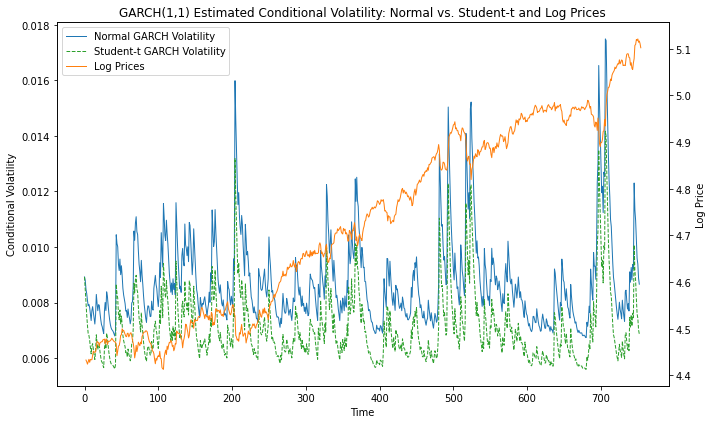

In [21]:
# Create the plot with dual y-axes
_, ax1 = plt.subplots(figsize=(10, 6))

# Plot sigma_fitted (Normal GARCH) on ax1
color_normal = 'tab:blue'
line1, = ax1.plot(sigma_fitted, label='Normal GARCH Volatility', color=color_normal, linewidth=1)
ax1.set_xlabel('Time')
ax1.set_ylabel('Conditional Volatility (Normal)')

# Plot sigma_fitted_t (Student-t GARCH) on ax1
color_student_t = 'tab:green'
line2, = ax1.plot(sigma_fitted_t, label='Student-t GARCH Volatility', color=color_student_t, linewidth=1, linestyle='--')
ax1.set_ylabel('Conditional Volatility')

# Create a second y-axis for log prices
ax2 = ax1.twinx()
color_logprice = 'tab:orange'
line3, = ax2.plot(daily_data["logprice"], label='Log Prices', color=color_logprice, linewidth=1)
ax2.set_ylabel('Log Price')

# Combine all lines for a single legend
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper left")

# Set the plot title
plt.title('GARCH(1,1) Estimated Conditional Volatility: Normal vs. Student-t and Log Prices')

# Improve layout and display the plot
plt.tight_layout()
plt.savefig("Condtional Variance.png")


Note that the student-t volatility is smaller since the student-t distribution has fatter tails, so a smaller volatility will have a heavier impact in this distribution than in the Normal Distribution.

## 5th Step: VaR calculation

Number of exceedances for Normal GARCH VaR: 39
Number of exceedances for t-distribution GARCH VaR: 40
Expected number of exceedances: 38.0


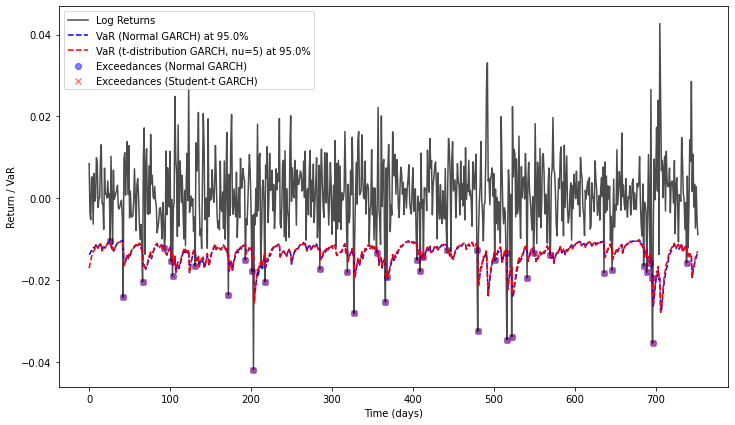

In [22]:
# Confidence level for VaR
confidence_level = 0.95
z_score = norm.ppf(1 - confidence_level)      # Quantile for normal distribution
t_score = t.ppf(1 - confidence_level, df=nu_est)  # Quantile for t-distribution (if estimated)

# Calculate VaR for each day
VaR_normal = mu_est + z_score * sigma_fitted
VaR_t = mu_est + t_score * sigma_fitted_t

# Plot returns and the two VaR estimates
plt.figure(figsize=(12, 7))
plt.plot(returns, label='Log Returns', color='black', alpha=0.7)
plt.plot(VaR_normal, label=f'VaR (Normal GARCH) at {confidence_level*100}%', color='blue', linestyle='--')
plt.plot(VaR_t, label=f'VaR (t-distribution GARCH, nu={nu_est}) at {confidence_level*100}%', color='red', linestyle='--')
plt.xlabel('Time (days)')
plt.ylabel('Return / VaR')
# plt.title('Moving Daily VaR (Normal and Student\'s t GARCH) vs. Log Returns')


# Count exceedances for both VaR calculations
exceedances_normal = np.sum(returns < VaR_normal)
exceedances_t = np.sum(returns < VaR_t)

# Highlight exceedances
plt.scatter(np.where(returns < VaR_normal)[0], returns[returns < VaR_normal],
    color='blue', marker='o', label='Exceedances (Normal GARCH)', alpha=0.5)
plt.scatter(np.where(returns < VaR_t)[0], returns[returns < VaR_t],
    color='red', marker='x', label='Exceedances (Student-t GARCH)', alpha=0.5)

plt.legend()
plt.savefig("GARCH VaR.png")

# Expected exceedances based on confidence level
expected_exceedances = np.ceil((1 - confidence_level) * len(returns))
print(f"Number of exceedances for Normal GARCH VaR: {exceedances_normal}")
print(f"Number of exceedances for t-distribution GARCH VaR: {exceedances_t}")
print(f"Expected number of exceedances: {expected_exceedances}")



Since we have computed the volatility for each model, the VaR should be similar for both.

In [23]:
# Define a range of confidence levels from 70% to 99.9%
# confidence_levels = np.arange(0.70, 0.999, 0.01)  # 70% to 99.9% in steps of 1%

# Initialize lists to store exceedance counts
exceedances_normal = []
exceedances_t = []
expected_exceedances = []

# Calculate Exceedances Across Confidence Levels

for cl in confidence_levels:
    # Calculate quantiles
    z_score = norm.ppf(1 - cl)  # Normal quantile
    t_score = t.ppf(1 - cl, df=nu_est)  # Student-t quantile
    
    # Calculate VaR for each day
    VaR_normal = mu_est + z_score * sigma_fitted
    VaR_t = mu_est_t + t_score * sigma_fitted_t
    
    # Count exceedances
    exceed_normal = np.sum(returns < VaR_normal)
    exceed_t = np.sum(returns < VaR_t)
    
    # Expected exceedances
    expected_exceed = np.ceil((1 - cl) * len(returns))
    
    # Append to lists
    exceedances_normal.append(exceed_normal)
    exceedances_t.append(exceed_t)
    expected_exceedances.append(expected_exceed)

# Convert lists to NumPy arrays for easier handling
exceedances_normal = np.array(exceedances_normal)
exceedances_t = np.array(exceedances_t)
expected_exceedances = np.array(expected_exceedances)


plt.figure(figsize=(9, 6))

# Plot expected exceedances
plt.plot(confidence_levels * 100, expected_exceedances, label='Expected Exceedances', color='grey', linestyle='--')

# Plot actual exceedances for Normal VaR
plt.plot(confidence_levels * 100, exceedances_normal, label='Actual Exceedances (Normal VaR)', color='blue', marker='o')

# Plot actual exceedances for Student-t VaR
plt.plot(confidence_levels * 100, exceedances_t, label='Actual Exceedances (Student-t VaR)', color='red', marker='x')

# Enhancements
plt.xlabel('Confidence Level (%)', fontsize=14)
plt.ylabel('Number of Exceedances', fontsize=14)
plt.title('VaR Exceedances Across Confidence Levels', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


summary_df = pd.DataFrame({
    'Confidence Level (%)': confidence_levels * 100,
    'Expected Exceedances': expected_exceedances.astype(int),
    'Actual Exceedances (Normal)': exceedances_normal,
    'Actual Exceedances (Student-t)': exceedances_t
})



NameError: name 'confidence_levels' is not defined

The VaR is better computed using the t-student distribution, which is what we expect. Also, note that in general Normal VaR is less conservative, a fact that is bad in Risk Management, since you don't want to underestimate your losses.

### Other fact to note is that both models underestimate VaR for smaller confidence intervals, is there something that we can say about this?

## 6th Step: VaR Comparison with previous models

## 7th Step: Conclusions? Improvements?

Improvements:
 - Backtesting the results of GARCH VaR by computing the GARCH VaR on previously unseen data (since all our data has been used for fitting the GARCH model) and test the efficacy on new data.
 - Compute Expected Shortfall instead of VaR, since it is better for Risk Management.
 - Implement more advanced GARCH models such as EGARCH.